# Imports

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data setup 

In [93]:
X = np.load("data/X-data.npy")
y = np.load("data/y-data.npy")

In [94]:
X = X.reshape(len(X), X.shape[1], 1)

# Class definitions

In [95]:
class Layer():  # Abstract class for layers
    def __init__(self):
        self.input = None
        self.output = None
        
    def forward(self, input):
        pass
    
    def backward(self, output, learning_rate):
        pass

In [96]:
# class Activation():
#     def activate(self, input):
#         return self.activation(self.input)

#     def activate_prime(self, output_gradient, learning_rate):
#         return np.multiply(output_gradient, self.activation_prime(self.input))
    
class ReLU():
    def activate(x):
        return np.maximum(0, x)

    def activate_prime(x):
        return (x > 0) * 1

class Sigmoid():
    def __init__(self):
        pass 
    
    def activate_prime(x):
        s = self.activate(x)
        return s * (1 - s)
    
    def activate(x):
        return 1 / (1 + np.exp(-x))

In [97]:
class Dense(Layer):
    def __init__(self, input_size, output_size, activation_function='relu'):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
        
        if activation_function == 'relu':
            self.activation_function = ReLU()
        elif activation_function == 'sigmoid':
            self.activation_function = Sigmoid()
        else:  # default to relu
            self.activation_function = ReLU()

    def forward(self, input):
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

# Helper functions

In [98]:
def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

# Training

#### Constants 

In [104]:
class Network():
    def __init__(
        self, layers, epochs=100, learning_rate=0.01, loss_function='binary_cross_entropy'
    ): 
        self.layers = layers
        self.epochs = epochs 
        self.learning_rate = learning_rate
            
        # For error visualisation.
        self.error_visualisation = []
        self.predictions = []
        
    def predict(self, x):
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        self.predictions.append(output)
        return output
            
    def train(self, X_train, y_train):
        for epoch in range(self.epochs):
            error = 0
            for x, y in zip(X_train, y_train):
                # forward
                output = self.predict(x)

                # error
                error += self.calculate_loss(y, output)

                # backward
                grad = self.calculate_loss_prime(y, output)
                for layer in reversed(self.layers):
                    grad = layer.backward(grad, self.learning_rate)

            error /= len(X_train)
            self.error_visualisation.append(error)
    
    def calculate_loss(self, y_true, y_pred):
        print('this is y_true: ', y_true)
        print('this is y_pred: ', y_pred)
        return np.mean(
            -y_true * np.log(y_pred.astype(float)) - (1 - y_true) * np.log(1 - y_pred)
        )
    
    def calculate_loss_prime(self, y_true, y_pred):
        return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)
    
    def plot_loss():
        pass

    def accuracy(): 
        pass 
        

In [105]:
input_shape = X.shape[1]

layers = [
    Dense(input_shape, 10, activation_function='relu'),
    Dense(10, 1, activation_function='sigmoid'),
]

In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

network = Network(layers, epochs=100, learning_rate=0.01)
network.train(X_train, y_train)

this is y_true:  1
this is y_pred:  [[-6.97537653]]
this is y_true:  1
this is y_pred:  [[-5.51058189]]
this is y_true:  1
this is y_pred:  [[-4.95602772]]
this is y_true:  0
this is y_pred:  [[-6.31782739]]
this is y_true:  1
this is y_pred:  [[-6.4043307]]
this is y_true:  0
this is y_pred:  [[-9.03621541]]
this is y_true:  1
this is y_pred:  [[-7.09319556]]
this is y_true:  1
this is y_pred:  [[-5.30881327]]
this is y_true:  1
this is y_pred:  [[-4.41514188]]
this is y_true:  1
this is y_pred:  [[-7.33952532]]
this is y_true:  0
this is y_pred:  [[-8.70742701]]
this is y_true:  1
this is y_pred:  [[-6.03462123]]
this is y_true:  0
this is y_pred:  [[-9.0358529]]
this is y_true:  1
this is y_pred:  [[-6.25739599]]
this is y_true:  1
this is y_pred:  [[-5.4598918]]
this is y_true:  1
this is y_pred:  [[-8.94658717]]
this is y_true:  1
this is y_pred:  [[-6.50969667]]
this is y_true:  1
this is y_pred:  [[-6.0929688]]
this is y_true:  1
this is y_pred:  [[-8.52498757]]
this is y_true: 

C:\Users\Laura\AppData\Local\Temp\ipykernel_34508\1573138022.py:42: RuntimeWarning: invalid value encountered in log
  -y_true * np.log(y_pred.astype(float)) - (1 - y_true) * np.log(1 - y_pred)


this is y_true:  0
this is y_pred:  [[-86.12303195]]
this is y_true:  1
this is y_pred:  [[-52.68142004]]
this is y_true:  1
this is y_pred:  [[-51.94312203]]
this is y_true:  1
this is y_pred:  [[-67.22343834]]
this is y_true:  0
this is y_pred:  [[-76.09103077]]
this is y_true:  1
this is y_pred:  [[-63.70575465]]
this is y_true:  0
this is y_pred:  [[-80.75165406]]
this is y_true:  1
this is y_pred:  [[-41.32047148]]
this is y_true:  1
this is y_pred:  [[-55.747751]]
this is y_true:  1
this is y_pred:  [[-53.84137331]]
this is y_true:  1
this is y_pred:  [[-59.17284849]]
this is y_true:  0
this is y_pred:  [[-71.1283038]]
this is y_true:  1
this is y_pred:  [[-57.08164151]]
this is y_true:  1
this is y_pred:  [[-54.49071357]]
this is y_true:  1
this is y_pred:  [[-56.09723948]]
this is y_true:  1
this is y_pred:  [[-53.13953598]]
this is y_true:  1
this is y_pred:  [[-61.0051045]]
this is y_true:  1
this is y_pred:  [[-57.85946253]]
this is y_true:  1
this is y_pred:  [[-61.80881391

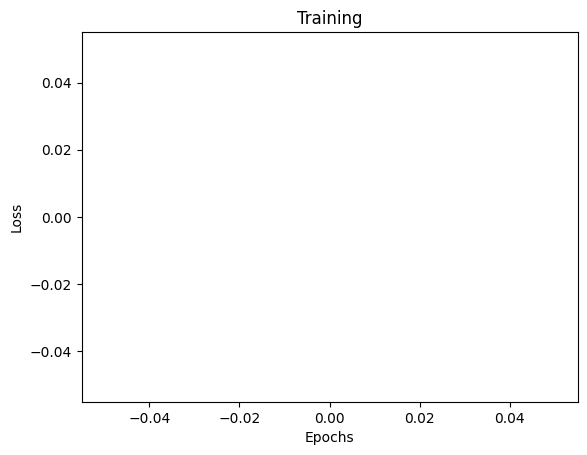

In [107]:
plt.plot(network.error_visualisation)
plt.title("Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Evaluation 

In [108]:
res = pd.DataFrame()
res["predictions"] = network.predictions
res["actual"] = y

ValueError: Length of values (569) does not match length of index (42600)

In [ ]:
res["predictions"] = res["predictions"].apply(lambda x: x[0][0])
res["predictions"] = res["predictions"].apply(lambda x: 0 if x < 0.5 else 1)
res

,predictions,actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
564,0,0
565,0,0
566,0,0
567,0,0


In [ ]:
print("Accuracy:",(len(res["predictions"] == res["actual"]) / len(X) * 100))

Accuracy: 100.0
